# Mahalanobis distance

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt

from pathlib import Path

/tmp/ipykernel_20801/3592290296.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def plot_test_distribution(test_dist, df_vector, path, file):

    import matplotlib.pyplot as plt

    x, y = np.mgrid[-3:9:.01, -3:9:.01]
    pos = np.dstack((x, y))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.contourf(x,y, test_dist.pdf(pos))
    ax.scatter(df_vector.X1, df_vector.X2, c='red', marker='x', s=5)
    ax.set_title('Mahalanobis distance between the datapoints (red) and the underlying distribution')

    plt.show()

In [3]:
def prepare_Mahalanobis_test(n_datapoints, path, file):
    '''
    # As a test, we compute the Mahalanobis distances of two vectors [2,2] and [-2, -2]
    # to a bivariate distribution of n_datapoints with a mean value: [3, 4]
    # and a covariance matrix [[ 2, -1], 
                               [-1,  2]]
    '''
    
    # prepare vector
    x1, x2 = [2,2], [-2, -2]
    vector = np.array([x1, x2])
    df_vector = pd.DataFrame({'X1': vector[:, 0], 'X2': vector[:, 1]})
    print('Vector=', df_vector)

    # prepare distribution
    import scipy as sp
    test_mean=np.array( [3, 4])
    test_cov=np.array([[2, -1], [-1, 2]])
    test_dist = sp.stats.multivariate_normal(mean=test_mean, cov=test_cov, seed=42)
    
    data = test_dist.rvs(n_datapoints)
    df_distrib = pd.DataFrame({'X1': data[:, 0], 'X2': data[:, 1]})
    print('Distribution (head) =')
    print(df_distrib[0:5])

    plot_test_distribution(test_dist, df_vector, None, None)

    return df_vector, df_distrib

In [4]:
def Mahalanobis_distance(df_vector, df_distrib, list_of_cols):

    # select data from dataframes
    # ---------------------------
    vector = pd.DataFrame(df_vector, columns=list_of_cols).to_numpy()
    distrib = pd.DataFrame(df_distrib, columns=list_of_cols).to_numpy()
    
    # Dealing with the distribution
    # -----------------------------
    
    # compute the mean
    distrib_mean = []
    for i in range(vector.shape[0]):  
        # we take the shape of vector, for later computing the difference vector - distrib_mean 
        distrib_mean.append(list(distrib.mean(axis=0)))

    # compute the covariance matrix
    # rowvar=False because each column represents a variable
    # alternative: cov_mat = np.cov(distrib.T) 
    cov_mat = np.cov(distrib, rowvar=False)
        
    # check that the covariance matrix is definite positive
    if is_pos_def(cov_mat):
        # compute the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov_mat)

        # check that the inverse covariance matrix is definite positive
        if is_pos_def(inv_cov):
            
    # compute Mahalanobis distance
    # ----------------------------
    
            # compute the difference (x-mu) 
            diff = vector - distrib_mean

            # compute the matrix product and take the sqrt 
            md = []
            md2 = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].T.dot(inv_cov).dot(diff[i])))
                md2.append(diff[i].T.dot(inv_cov).dot(diff[i]))
        else:
            print("The inverse of the covariance matrix is not definite positive")
    else:
        print("The covariance matrix is not definite positive")

    result = df_vector.copy().assign(Mahalanobis = md, Mahalanobis_squared = md2)

    return result, distrib_mean[0], cov_mat

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

Vector=    X1  X2
0   2   2
1  -2  -2
Distribution (head) =
         X1        X2
0  2.293884  4.510580
1  3.283692  5.870198
2  3.121218  3.547662
3  1.608526  6.476791
4  3.958634  3.808662


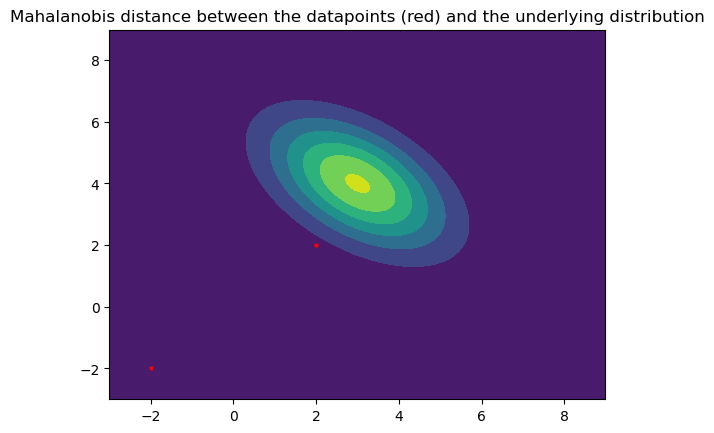

In [5]:
df_vector, df_distrib = prepare_Mahalanobis_test(100000, None, None)

In [6]:
MD_test, mean_test, cov_test =  Mahalanobis_distance(df_vector, df_distrib, ['X1', 'X2'])
MD_test 

,X1,X2,Mahalanobis,Mahalanobis_squared
0,2,2,2.160731,4.668759
1,-2,-2,7.799678,60.834979


In [7]:
# TBD save figure

# Using the Mahalanobis distance to identify outliers

##### For that purpose, we will use the New York airquality dataset, which measures daily the air quality in New York, from May to September 1973.

In [8]:
path_data = Path('/home/lemasle/PROJECTS/datasets/NY_air_quality_1973')

In [9]:
file = path_data / 'airquality.csv'
air_qual = pd.read_csv(file, index_col=0)
air_qual.describe()

,Ozone,Solar.R,Wind,Temp,Month,Day
count,116.000000,146.000000,153.000000,153.000000,153.000000,153.000000
mean,42.129310,185.931507,9.957516,77.882353,6.993464,15.803922
std,32.987885,90.058422,3.523001,9.465270,1.416522,8.864520
min,1.000000,7.000000,1.700000,56.000000,5.000000,1.000000
25%,18.000000,115.750000,7.400000,72.000000,6.000000,8.000000
50%,31.500000,205.000000,9.700000,79.000000,7.000000,16.000000
75%,63.250000,258.750000,11.500000,85.000000,8.000000,23.000000
max,168.000000,334.000000,20.700000,97.000000,9.000000,31.000000


In [10]:
# select only two variables and drop NaNs
data = air_qual[['Ozone','Temp']].dropna().drop_duplicates(keep='first')
data.head()

,Ozone,Temp
1,41.0,67
2,36.0,72
3,12.0,74
4,18.0,62
6,28.0,66


In [11]:
def prepare_ellipse_for_plot(critical_value, cov_mat):

    # only uses the covariance matrix for determining the ellipse
    eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
    theta = np.linspace(0, 2*np.pi, 1000);
    ellipse = (np.sqrt(critical_value)*np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)]
    x = ellipse[0,:] + meanx
    y = ellipse[1,:] + meany
    
    return x,y

In [12]:
def NY_ozone_plot(data, outliers, meanx, meany, cov, critical_value, path, filename):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.scatter(data.Ozone, data.Temp, c='black', marker='.', s=10)
    ax.scatter(meanx, meany, c='darkgreen', marker='x', s=20)
    ax.scatter(outliers.Ozone, outliers.Temp, c='red', marker='o', s=10)
    ax.set_xlabel('Ozone (ppb)')
    ax.set_ylabel('Temperature (F)')
    ax.set_title('Temperature vs Ozone variations, New York, May-September 1973')

    x,y = prepare_ellipse_for_plot(critical_value, cov)
    
    ax.fill(x, y, facecolor='gray', alpha=0.15, edgecolor='darkgreen', lw=2)

In [13]:
weather, mean, cov_mat = Mahalanobis_distance(data, data, ['Ozone', 'Temp'])

The square of Mahalanobis distance follows a chi-square distribution.

In [14]:
def get_critical_value_for_outliers(dof, sig_lev):

    from scipy.stats import chi2

    # compute the critical value for a given significance level sig_lev
    # assuming a chi-square distribution with a dof number of degrees of freedom 
    
    return chi2.ppf((1-sig_lev), df=dof)

In [15]:
critical_value = get_critical_value_for_outliers(1, 0.01)
print(critical_value)

6.6348966010212145


In [16]:
out1 = weather.loc[weather.Mahalanobis_squared>critical_value]
out1

,Ozone,Temp,Mahalanobis,Mahalanobis_squared
30,115.0,79,2.956284,8.739615
62,135.0,84,3.356373,11.265238
117,168.0,81,5.006520,25.065241


In [17]:
meanx, meany = mean[0], mean[1]

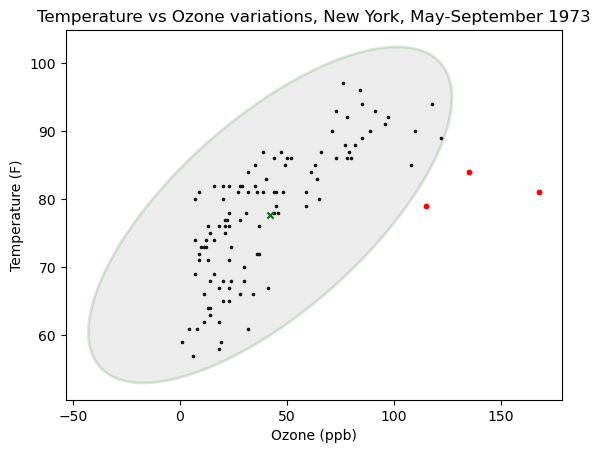

In [18]:
NY_ozone_plot(weather, out1, meanx, meany, cov_mat, critical_value, None, None)

We can also think in terms of p values:
The square of the Mahalanobis distance D² can me mapped into a probability thanks to a chi-squared cumulative probability distribution. The Mahalanobis distances ends up on [0-1] scale, which indicates the probability P(chi²<D²) that a given datapoint as a greater Mahalanobis distances than would be expected by chance.

In [19]:
def compute_p_values(df, dof):

    from scipy.stats import chi2
    df['p_value'] = 1 - chi2.cdf(df['Mahalanobis_squared'], dof)

    return df

In [20]:
weather = compute_p_values(weather, 1)
weather.head()

,Ozone,Temp,Mahalanobis,Mahalanobis_squared,p_value
1,41.0,67,1.525424,2.326918,0.127153
2,36.0,72,0.673954,0.454214,0.500341
3,12.0,74,0.979525,0.959469,0.327321
4,18.0,62,1.735461,3.011824,0.082659
6,28.0,66,1.355684,1.837880,0.175200


In [21]:
out2 = weather.loc[weather.p_value<0.01]
out2

,Ozone,Temp,Mahalanobis,Mahalanobis_squared,p_value
30,115.0,79,2.956284,8.739615,3.113703e-03
62,135.0,84,3.356373,11.265238,7.897207e-04
117,168.0,81,5.006520,25.065241,5.542294e-07


Luckily, we find the same outliers!

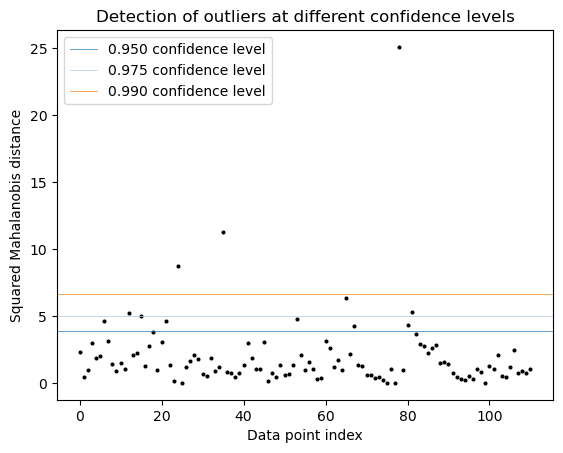

In [22]:
def plot_outliers_vs_confidence(D2, list_of_conf_levels, dof):

    from scipy.stats import chi2
    import matplotlib.colors as cm
    
    x = range(len(D2))
    colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.scatter(x, D2, c='black', marker='.', s=15)

    for i, lev in enumerate(list_of_conf_levels):
        text = "{:.3f} confidence level".format(1-lev)
        ax.axhline(y=get_critical_value_for_outliers(1,lev), xmin=0, xmax=len(D2), c=str(colors[i]), label = text, linestyle = "solid", lw=0.5) 

    ax.legend()
    ax.set_ylabel("Squared Mahalanobis distance")
    ax.set_xlabel("Data point index")
    ax.set_title( 'Detection of outliers at different confidence levels' )

    plt.show()

plot_outliers_vs_confidence(weather.Mahalanobis_squared, [0.050, 0.025, 0.01], 1)

# Dealing with "real" data.

In practice, the data might be plagued by strong outliers that would falsify the determination of the mean values and the covariances, and in turn, of the Mahalanobis distance. However, there are ways to make the Mahalanobis distance robust to outliers.

A more robust estimate or´f the mean and the covariance matrix can be obtained via the Minimum Covariance Determinant method, which only uses a subset of the whole sample, for which the determinant of the covariant matrix is minimum as one could guess from the method's name.

In [23]:
def Robust_Mahalanobis_distance(df_vector, df_distrib, list_of_cols, method):

    from sklearn.covariance import MinCovDet, EmpiricalCovariance
    
    # select data from dataframes
    # ---------------------------
    vector = pd.DataFrame(df_vector, columns=list_of_cols).to_numpy()
    distrib = pd.DataFrame(df_distrib, columns=list_of_cols).to_numpy()
    
    # Dealing with the distribution
    # -----------------------------

    # compute a covariance matrix robust to outliers
    if method == 'Empirical':
        cov = EmpiricalCovariance(assume_centered=False).fit(distrib)
    elif method == 'MinCovDet':
        cov = MinCovDet().fit(distrib)
    else: 
        print('Method not included in this function')
        
    robust_cov = cov.covariance_
    print('robust_cov:', robust_cov)
    # compute a robust mean
    robust_mean = cov.location_
    print('robust_mean:', robust_mean)
    distrib_robust_mean = []
    for i in range(vector.shape[0]):  
        # we take the shape of vector, for later computing the difference vector - distrib_mean 
        distrib_robust_mean.append(list(robust_mean))
    
    # check that the covariance matrix is definite positive
    if is_pos_def(robust_cov):
        # compute the inverse of the covariance matrix
        inv_cov = np.linalg.inv(robust_cov)

        # check that the inverse covariance matrix is definite positive
        if is_pos_def(inv_cov):
            
    # compute Mahalanobis distance
    # ----------------------------
    
            # compute the difference (x-mu) 
            diff = vector - distrib_robust_mean

            # compute the matrix product and take the sqrt 
            md = []
            md2 = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].T.dot(inv_cov).dot(diff[i])))
                md2.append(diff[i].T.dot(inv_cov).dot(diff[i]))
        else:
            print("The inverse of the covariance matrix is not definite positive")
    else:
        print("The covariance matrix is not definite positive")

    result = df_vector.copy().assign(Mahalanobis = md, Mahalanobis_squared = md2)

    return result, robust_mean, robust_cov

In [24]:
weather_robust, mean_robust, cov_robust = Robust_Mahalanobis_distance(data, data, ['Ozone', 'Temp'], 'MinCovDet')
weather_robust

robust_cov: [[521.4171 159.9815]
 [159.9815  85.4675]]
robust_mean: [34.27 76.55]


,Ozone,Temp,Mahalanobis,Mahalanobis_squared
1,41.0,67,1.948055,3.794918
2,36.0,72,0.845744,0.715283
3,12.0,74,1.206378,1.455348
4,18.0,62,1.737443,3.018708
6,28.0,66,1.456262,2.120698
...,...,...,...,...
148,14.0,63,1.505024,2.265097
149,30.0,70,0.888616,0.789638
151,14.0,75,1.177814,1.387245
152,18.0,76,1.024701,1.050013


In [25]:
out_robust1 = weather_robust.loc[weather_robust.Mahalanobis_squared>critical_value]
out_robust1

,Ozone,Temp,Mahalanobis,Mahalanobis_squared
30,115.0,79,5.117808,26.191956
62,135.0,84,5.880651,34.582051
69,97.0,92,2.818348,7.943087
86,108.0,85,3.993250,15.946043
99,122.0,89,4.529220,20.513832
101,110.0,90,3.692007,13.630917
117,168.0,81,8.430879,71.079729
121,118.0,94,3.913028,15.311786
124,96.0,91,2.803976,7.862280


In [26]:
weather_robust = compute_p_values(weather_robust, 1)
weather_robust.head()

,Ozone,Temp,Mahalanobis,Mahalanobis_squared,p_value
1,41.0,67,1.948055,3.794918,0.051408
2,36.0,72,0.845744,0.715283,0.397695
3,12.0,74,1.206378,1.455348,0.227672
4,18.0,62,1.737443,3.018708,0.082309
6,28.0,66,1.456262,2.120698,0.145320


In [27]:
out_robust2 = weather_robust.loc[weather_robust.p_value<0.01]
out_robust2

,Ozone,Temp,Mahalanobis,Mahalanobis_squared,p_value
30,115.0,79,5.117808,26.191956,3.091075e-07
62,135.0,84,5.880651,34.582051,4.086571e-09
69,97.0,92,2.818348,7.943087,4.827142e-03
86,108.0,85,3.993250,15.946043,6.517388e-05
99,122.0,89,4.529220,20.513832,5.920188e-06
101,110.0,90,3.692007,13.630917,2.224912e-04
117,168.0,81,8.430879,71.079729,0.000000e+00
121,118.0,94,3.913028,15.311786,9.114607e-05
124,96.0,91,2.803976,7.862280,5.047669e-03


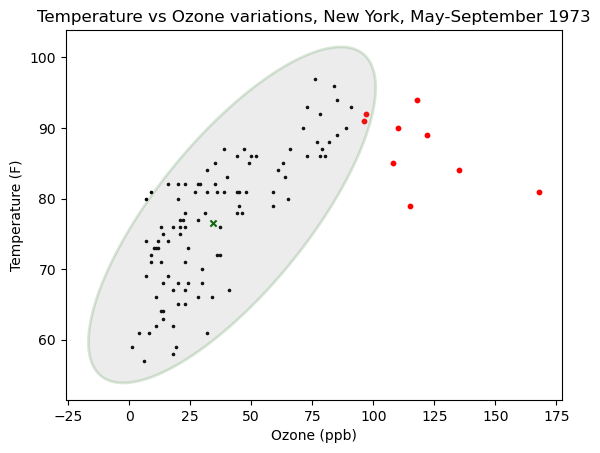

In [28]:
NY_ozone_plot(weather_robust, out_robust1, mean_robust[0], mean_robust[1], cov_robust, critical_value, None, None)

Again, we spot the same outliers using the critical value or the p-values. However, using robust values for the mean and the covariance matrix leads to larger number of potential outliers. 

In [29]:
weather_empirical, mean_empirical, cov_empirical = Robust_Mahalanobis_distance(data, data, ['Ozone', 'Temp'], 'Empirical')
weather_empirical

robust_cov: [[1078.16427238  218.71544517]
 [ 218.71544517   90.95463031]]
robust_mean: [42.12612613 77.68468468]


,Ozone,Temp,Mahalanobis,Mahalanobis_squared
1,41.0,67,1.532342,2.348071
2,36.0,72,0.677010,0.458343
3,12.0,74,0.983967,0.968191
4,18.0,62,1.743331,3.039205
6,28.0,66,1.361833,1.854588
...,...,...,...,...
148,14.0,63,1.569825,2.464352
149,30.0,70,0.849917,0.722359
151,14.0,75,0.964171,0.929626
152,18.0,76,0.872347,0.760989


A somewhat similar result (not invoking the Mahalanobis distance) can be obtained using the EllipticEnvelope method together with the 
DecisionBoundaryDisplay tool. However, this algorithm requires the prior knowledge of the contamination level. Moreover, it uses the empirical covariance estimate, which is not robust.

In [30]:
def EllipticEnvelope(data, support_fraction, contamination_level, outliers):

    from sklearn.covariance import EllipticEnvelope
    from sklearn.inspection import DecisionBoundaryDisplay

    # outliers have been determined via an independent method
    
    estimator = EllipticEnvelope(support_fraction=support_fraction, contamination=contamination_level)
    estimator.fit(data)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.scatter(data.Ozone, data.Temp, c='black', marker='.', s=10)

    DecisionBoundaryDisplay.from_estimator(
        estimator,
        data,
        response_method="decision_function",
        plot_method="contour",
        levels=[0],
        colors='darkgreen',
        ax=ax,
        grid_resolution=200,
        eps=2.0
    )
    
    ax.set_xlabel('Ozone (ppb)')
    ax.set_ylabel('Temperature (F)')
    ax.set_title('Temperature vs Ozone variations, New York, May-September 1973')
    ax.set_xlim([-25,175])
    ax.set_ylim([50,105])
    ax.scatter(outliers.Ozone, outliers.Temp, c='red', marker='o', s=10)

    plt.show()


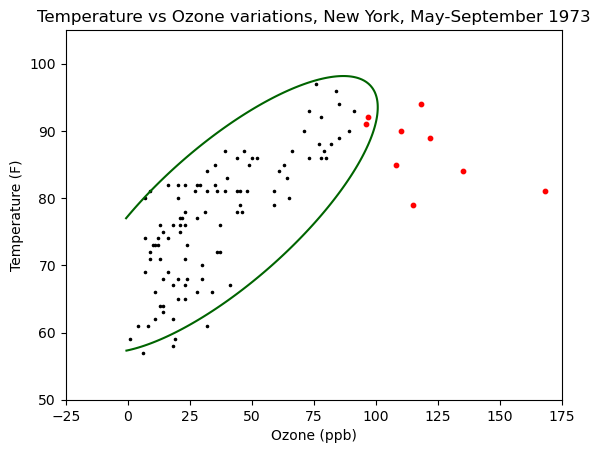

In [31]:
EllipticEnvelope(data, 1.0, 0.1, out_robust1)
# The ellipse stops at x=0 because there are no datapoints below this value